In [1]:
import networkx as nx
from anytree import Node, RenderTree, PreOrderIter, PostOrderIter, findall

In [2]:
import networkx as nx
from utils.randomstructure import generate_random_prob
from graph.graphview import digraph_repr, draw
from copy import deepcopy

In [3]:
# only leafs are explicit
root = Node('root')
f0 = Node('f0', parent=root)
s1 = Node('solver1', parent=root)
f3 = Node('f3', parent=root)
f1 = Node('f1', parent=s1)
f2 = Node('f2', parent=s1)
r1 = Node('r1', end=True, parent=s1)

Storyline for conceptual design model starting bottoms up
- top-down: we can create an implicit tree node from scratch where we must specify for which variables we are solving each end component (function) 
- OR bottoms-up: we can create it from merging existing nodes in an already existing structure (manipulating an existing tree)
    - this now becomes a node we can operate on: it can be standardized

In [4]:
incstr = {
    'f0': ('x','y'),   
    'f1': ('a','c','y'),    # analysis f1(c, y)
    'f2': ('a','b'),    # analysis f2(a)
    'r1': ('b','d'),     # function 
    'f3': ('e','c', 'b')
         }

solvefor = {
    'f0': 'y',   # should not be c, given that solvefor for r1 is c
    'f1': 'a',
    'f2': 'b',
    'f3': 'e',    # should not be c, given that solvefor for r1 is c
    'r1': 'c' #(? when not assigned) # for 'diagonalized' DSM should be 'd'
    # note also that 'c' has to be an input upstream of 'r1', but if r1 is under a solver, then 'c' can not be an output of any node outside
}

In [5]:
def solvef(fname):
    if fname in solvefor:
        sfor = solvefor[fname] 
        return (sfor, [elt for elt in incstr[fname] if elt != sfor])
    return ""

# Generate notation

In [6]:
for pre, _, node in RenderTree(root):
    treestr = u"%s%s" % (pre, node.name)
    print(treestr.ljust(16), solvef(node.name))

root             
├── f0           ('y', ['x'])
├── solver1      
│   ├── f1       ('a', ['c', 'y'])
│   ├── f2       ('b', ['a'])
│   └── r1       ('c', ['b', 'd'])
└── f3           ('e', ['c', 'b'])


In [7]:
# in datastructures.py
def notation(x):
    nt = []
    endcomps = []
    solvefr = []
    for elt in x.children:
        if elt.is_leaf:
            if hasattr(elt, 'end'):
                endcomps.append(elt.name)
                solvefr.append(solvefor[elt.name])
            else:
                nt.append((solvefor[elt.name], elt.name))
        else:
            nt.append(notation(elt))
    nt.extend(endcomps)
    if solvefr:
        return (solvefr, nt)
    else:
        return nt

In [8]:
notation(root)

[('y', 'f0'), (['c'], [('a', 'f1'), ('b', 'f2'), 'r1']), ('e', 'f3')]

# Standardize:

In [9]:
root.children = [elt for child in root.children for elt in ([child] if child != s1 else child.children)]

In [10]:
for pre, _, node in RenderTree(root):
    treestr = u"%s%s" % (pre, node.name)
    print(treestr.ljust(16), solvef(node.name))

root             
├── f0           ('y', ['x'])
├── f1           ('a', ['c', 'y'])
├── f2           ('b', ['a'])
├── r1           ('c', ['b', 'd'])
└── f3           ('e', ['c', 'b'])


In [11]:
notation(root)

(['c'], [('y', 'f0'), ('a', 'f1'), ('b', 'f2'), ('e', 'f3'), 'r1'])

# Merge

In [12]:
# only leafs are explicit
treeroot = Node('root')
f0 = Node('f_0', parent=treeroot)
f1 = Node('f_1', parent=treeroot)
f2 = Node('f_2', parent=treeroot)
f3 = Node('f_3', parent=treeroot)
f4 = Node('f_4', parent=treeroot)
r1 = Node('r_1', end=True, parent=treeroot)

In [13]:
root = nx.DiGraph([('x_0', 'f_1'), ('f_1', 'x_2'), ('x_1', 'f_1'), ('x_2', 'f_2'), ('x_3', 'f_2'), ('x_3', 'f_1'), ('x_5', 'f_3'), 
                   ('x_1', 'f_3'), ('f_3', 'x_3'), ('x_3', 'r_1'), ('x_4', 'r_1'), ('x_1', 'f_4'), ('f_4', 'x_6')])

In [14]:
def circular_vars(graph):
    return {elt:'o' if elt in ['x_0','x_1','x_2','x_3','x_4','x_5', 'x_6'] else 's' for elt in graph.nodes()}

In [15]:
def drawfull(graph, prog='neato'):
    draw(graph, node_shape=circular_vars(graph), arc=0.1, prog=prog);

In [16]:
def merge(G, treeroot, mergelts, mgroupname, mergewithold=True, solvefor=None, solvefortable=None):
    #Graph
    solvefor = [] if solvefor == None else solvefor
    solvefortable = dict() if solvefortable == None else solvefortable
    allsolvevars = set()
    for solvevar, res in solvefor:
        mergelts.append(res)
        allsolvevars.add(solvevar)
    edges = G.edges()
    mergededges = [(fr,to) for fr,to in edges if fr in mergelts or to in mergelts]
    outs = {to for fr,to in edges if fr in mergelts and not all([elt in mergelts for elt in G.successors(to)])}
    outs = outs.union(allsolvevars) # for every terminal node can have one solvefor
    ins = {fr for fr,to in edges if (
        to in mergelts 
        and not any([elt in mergelts for elt in G.predecessors(fr)]) 
        and fr not in allsolvevars)}
    newedges = [(fr, mgroupname) for fr in ins]+[(mgroupname, to) for to in outs]
    if mergewithold:
        oldedges = [(fr, to) for fr,to in edges if fr not in mergelts and to not in mergelts]
        newedges += oldedges
    # Tree
    treeroot = deepcopy(treeroot)
    solvefortable = solvefortable.copy()
    solvefortable[mgroupname] = solvefor
    newsolver = Node(mgroupname, parent=treeroot)
    for elt in findall(treeroot, filter_=lambda node: node.name in mergelts):
        elt.parent = newsolver
    return nx.DiGraph(newedges), nx.DiGraph(mergededges), treeroot, solvefortable

In [17]:
ch1, ch2, treerootn, solvefortable = merge(root, treeroot, ['f_1','f_2'], 'm1', solvefor=[('x_1', 'r_1')])

In [18]:
for pre, _, node in RenderTree(treerootn):
    treestr = u"%s%s" % (pre, node.name)
    print(treestr.ljust(16))

root            
├── f_0         
├── f_3         
├── f_4         
└── m1          
    ├── f_1     
    ├── f_2     
    └── r_1     


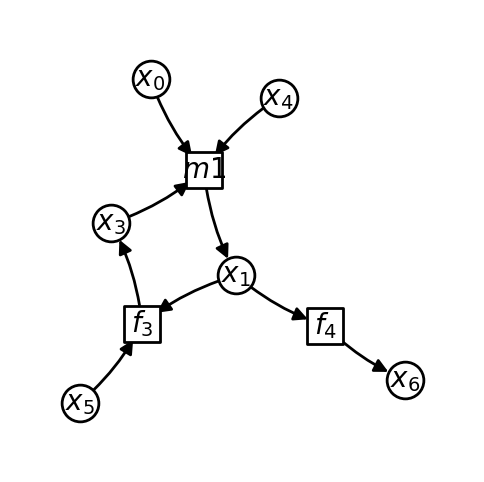

In [19]:
drawfull(ch1)

In [20]:
eqsn = [node.name for node in PreOrderIter(treerootn)]
C = nx.condensation(ch1)
order = []
for n in nx.topological_sort(C):
    filtereqs = {elt for elt in C.nodes[n]['members'] if elt in eqsn}
    if filtereqs:
        order.append(filtereqs)

In [21]:
order

[{'f_3', 'm1'}, {'f_4'}]